# PyTorch Insurance Charges Predictor

This is a follow up to the post: [A Practical Approach to Building and Evaluating Machine Learning Models](https://blog.kmillerapps.com/post/a-practical-approach-to-building-and-evaluating-machine-learning-models)
- In this post, I will use PyTorch to see if I can get a better performance. This post will not be as detailed as the original post, but I will comment as best as I can so that you can follow.

## 1. Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2. Load Data

In [2]:
# Load data
df = pd.read_csv('./insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 3. Preprocess

In [3]:
# Feature Engineering: Add extra column
bins = [0, 18, 30, 50, 70, float('inf')]  # Age ranges. Use float('inf') so that we don't have to manually set upperbound
labels = [0, 1, 2, 3, 4]  # Corresponding labels
df['age_range'] = pd.cut(df['age'], bins=bins, labels=labels, right=False ) # right=False to get distinct ranges, no overlaps
df.head()

,age,sex,bmi,children,smoker,region,charges,age_range
0,19,female,27.900,0,yes,southwest,16884.92400,1
1,18,male,33.770,1,no,southeast,1725.55230,1
2,28,male,33.000,3,no,southeast,4449.46200,1
3,33,male,22.705,0,no,northwest,21984.47061,2
4,32,male,28.880,0,no,northwest,3866.85520,2


In [4]:
# Normalize and Encode the data
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), ['age', 'bmi', 'children']),
        ('cat_nom', OneHotEncoder(), ['sex', 'smoker', 'region']),
        ('cat_ord', OrdinalEncoder(), ['age_range'])
    ],
    remainder='passthrough'
)

## 4. Split data into training, validation and testing sets

In [5]:
# Shuffle as the plan is the manually take 85% for Train/Test and leave 15% for Validation
df_shuffle = df.sample(frac=1, random_state=42).reset_index(drop=True)
df_shuffle.head()

,age,sex,bmi,children,smoker,region,charges,age_range
0,45,female,25.175,2,no,northeast,9095.06825,2
1,36,female,30.020,0,no,northwest,5272.17580,2
2,64,female,26.885,0,yes,northwest,29330.98315,3
3,46,male,25.745,3,no,northwest,9301.89355,2
4,19,male,31.920,0,yes,northwest,33750.29180,1


In [6]:
# Check the shape
df_shuffle.shape

(1338, 8)

In [7]:
# Take 85% of the data to split into Train/Test. The other 15% will be for validation
train_test = int(0.85 * df_shuffle.shape[0])
df_train_test = df_shuffle[:train_test]
df_train_test.shape

(1137, 8)

In [8]:
# Check the remaining for validation
df_validation = df_shuffle[train_test:]
df_validation.shape

(201, 8)

In [9]:
# Train and Test Set
X = df_train_test.drop(columns='charges')  # Features
y = df_train_test['charges']  # Target

# Split the 85% of total dataset into Train/Test using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare validation Set
X_val = df_validation.drop(columns='charges') # Features for Validation
y_val = df_validation['charges'] # Target for Validation

print(f"X_train : {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train : {y_train.shape}")
print(f"y_test: {y_test.shape}")
print("\n")
print(f"X_val : {X_val.shape}")
print(f"y_val: {y_val.shape}")


X_train : (909, 7)
X_test: (228, 7)
y_train : (909,)
y_test: (228,)


X_val : (201, 7)
y_val: (201,)


In [10]:
# Apply preprocessing to features
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

In [11]:
# convert the data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

In [12]:
# Convert to tensor and ensure the shape is a column vector using .view(-1, 1)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# 5. Define PyTorch Model

In [13]:
class InsuranceRegressionModel(nn.Module):
    def __init__(self, input_dim, hidden1=32, hidden2=64):
        super(InsuranceRegressionModel, self).__init__()
        # Define a simple feedforward neural network with one hidden layer
        self.connected1 = nn.Linear(input_dim, hidden1)  # 32 default neurons in the hidden1 layer
        self.relu = nn.ReLU()  # ReLU activation function
        self.connected2 = nn.Linear(hidden1, hidden2)
        self.output = nn.Linear(hidden2, 1)  # Output layer (1 for regression)

    def forward(self, x):
        x = self.connected1(x)
        x = self.relu(x)
        x = self.connected2(x)
        x = self.output(x)
        return x


In [14]:
# Instantiate the model
model = InsuranceRegressionModel(input_dim=X_train.shape[1])

In [15]:
# Step 5: Define the loss function and optimizer
loss_fn = nn.MSELoss()  # Mean Squared Error (MSE) loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

In [16]:
# Step 6: Training the model with validation set
n_epochs = 10000
training_losses = []
validation_losses = []
for epoch in range(n_epochs):
    
    # Set model to training mode
    model.train()  
    
    # Zero the gradients before running the backward pass
    optimizer.zero_grad()
    
    # Forward pass -- Compute predicted charges by passing X_train through the model
    y_pred_train = model(X_train_tensor)
    
    # Compute the loss on the training set
    train_loss = loss_fn(y_pred_train, y_train_tensor)
    training_losses.append(train_loss.item())
    
    # Backward pass -- Compute gradient of the loss w.r.t. to model parameters
    train_loss.backward()
    
    # Update parameters using the optimizer
    optimizer.step()
    
    # Validation phase -- Compute loss on the validation set
    model.eval()  # Set model to evaluation mode (no gradient computation)
    with torch.no_grad():  # No need to track gradients during validation
        y_pred_val = model(X_val_tensor)
        val_loss = loss_fn(y_pred_val, y_val_tensor)
        validation_losses.append(val_loss.item())
    
    # Print the training and validation loss every 100 epochs
    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}')


Epoch [1000/10000], Train Loss: 100962144.0000, Val Loss: 98726376.0000
Epoch [2000/10000], Train Loss: 42176300.0000, Val Loss: 39967220.0000
Epoch [3000/10000], Train Loss: 34007108.0000, Val Loss: 30620632.0000
Epoch [4000/10000], Train Loss: 29735818.0000, Val Loss: 27427832.0000
Epoch [5000/10000], Train Loss: 26510882.0000, Val Loss: 24808692.0000
Epoch [6000/10000], Train Loss: 25005498.0000, Val Loss: 23995366.0000
Epoch [7000/10000], Train Loss: 24483010.0000, Val Loss: 23914210.0000
Epoch [8000/10000], Train Loss: 24261950.0000, Val Loss: 23923108.0000
Epoch [9000/10000], Train Loss: 24151316.0000, Val Loss: 23928700.0000
Epoch [10000/10000], Train Loss: 24081660.0000, Val Loss: 23992286.0000


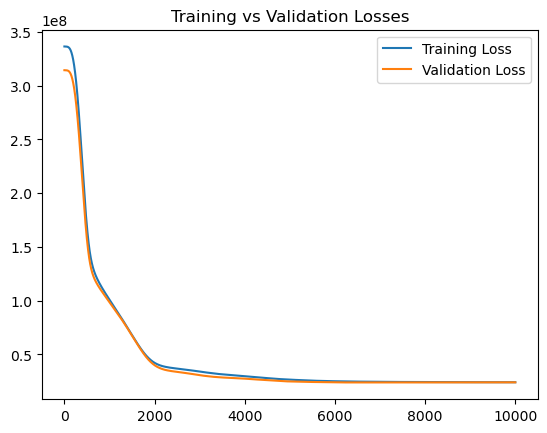

In [17]:
# Step 6: Plot the Losses for Training and Validation to see if both are decreasing or if our model is overfitting
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.legend()
plt.title('Training vs Validation Losses')
plt.show()

In [18]:
# Step 7: Evaluate the model on the test set
model.eval()  # Set the model to evaluation mode for inference
with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    
    # Calculate the RMSE (Root Mean Squared Error) on the test set
    rmse = torch.sqrt(loss_fn(y_pred_test, y_test_tensor))
    print(f'Test RMSE: {rmse.item():.4f}')
    
    # Calculate the Mean Squared Error (MSE) for the test set
    mse = mean_squared_error(y_test, y_pred_test.numpy())
    print(f'Mean Squared Error (MSE) on test set: {mse:.4f}')

Test RMSE: 3774.3550
Mean Squared Error (MSE) on test set: 14245755.2909


In [19]:
#y_pred_test

In [20]:
#y_test_tensor

In [21]:
y_predicted = y_pred_test.flatten().tolist()
y_actual = y_test_tensor.flatten().tolist()

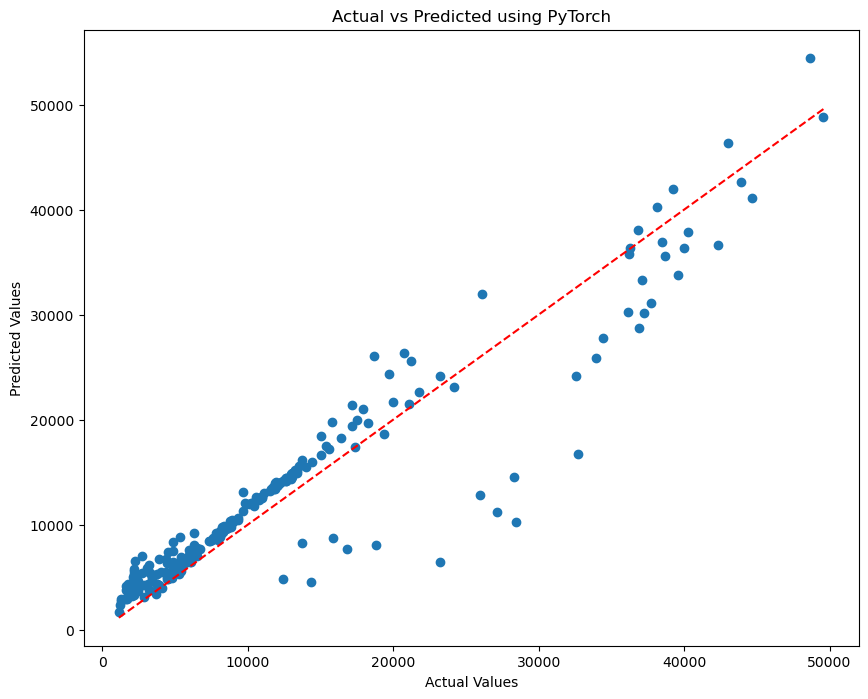

In [22]:
# Using the same code from our first Post with minor modifications
plt.figure(figsize=(10, 8))
plt.scatter(y_actual, y_predicted)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted using PyTorch')
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--')
plt.show()

# 6. Conclusion

The first thing to notice from our Train vs Validation plot, is that from all indications, it does not seem like our model is overfitting on the training data. Both curves are trending downwards. Using PyTorch gave us a better overall score for the Root Mean Squared Error (RMSE). Here we got a score of 3774 and before, the score was 5801 for the Linear Regression (LR) Model and 4531 for the Kernel Ridge (KR) model. This shows that using a deep learning model, would perform better especially if we finetune it some more.   